In [411]:
import os

import torch
from torch import nn
from torch.optim import SGD, Adam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Normal
from torch.utils.tensorboard import SummaryWriter

In [412]:
%load_ext tensorboard

# # Clear any logs from previous runs
# rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Generate toy data

In [413]:
DEVICE = 'cpu'

# Generate some simple data
#p_z = Normal(0.0, 1.0)  # Prior
N = 4000
t = np.linspace(0,1,128)    # time stamps
f = 3.0                  # frequency in Hz
x = np.zeros((N,128))       # data shape
phase = np.random.uniform(-np.pi, np.pi, size=N)
for i in range(N):
    x[i,:] = np.sin(2*np.pi*t*f + phase[i])

# Make training and test data set
indices = np.random.permutation(N)
train_index, test_index, val_index = indices[:int(0.8*N)], indices[int(0.8*N):int(0.9*N)], indices[int(0.9*N):]
train_data = torch.from_numpy(x[train_index].astype(np.float32)).to(DEVICE)
test_data = torch.from_numpy(x[test_index].astype(np.float32)).to(DEVICE)
val_data = torch.from_numpy(x[val_index].astype(np.float32)).to(DEVICE)
#train_data = torch.unsqueeze(train_data,1)
print("Data shape training:", train_data.shape)
print("Data shape testing:", test_data.shape)
print("Data shape validation:", val_data.shape)

Data shape training: torch.Size([3200, 128])
Data shape testing: torch.Size([400, 128])
Data shape validation: torch.Size([400, 128])


In [414]:
# train_values = train_data.cpu().detach().numpy().ravel()
# mean = np.mean(train_values)
# plt.axvline(mean, color = "grey", linestyle='dashed')
# sns.kdeplot(train_values)

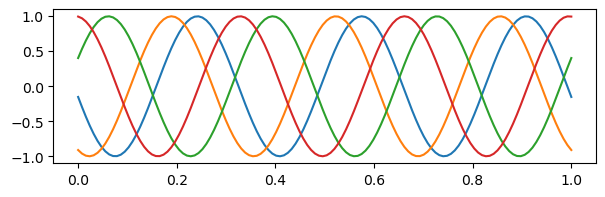

In [415]:
# Plot 4 random data points
plt.figure(figsize=(7,2))
for i in range(4):
    plt.plot(t,x[np.random.randint(0,127),:])
plt.show()

In [416]:
print(train_data.dtype)

torch.float32


# Make model

In [417]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,32)
        self.mu = nn.Linear(32,1)
        self.var = nn.Linear(32,1)

        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
    
    def forward(self, x):
        h1 = self.activation(self.fc1(x))
        h1 = self.activation(self.fc2(h1))
        return self.mu(h1), self.var(h1)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(1,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()

    def forward(self, z):
        h1 = self.activation(self.fc1(z))
        h1 = self.activation(self.fc2(h1))
        #return self.mu(h1), self.var(h1)
        return torch.tanh(self.fc3(h1))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparametrization(self, mean, var):
        eps = torch.randn_like(var).to(DEVICE) # Ransom tensor is same shape as var
        z = mean + var*eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [418]:
alpha = 0.01
def loss_function(x, out, mean, log_var):
    """
    Loss function for the model
    """
    x_hat=out
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    #print("Loss:", (1-alpha)*reproduction_loss, KL_divergence*alpha)
    return (1-alpha)*reproduction_loss + KL_divergence*alpha

In [419]:
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)
model = Model(encoder, decoder).to(DEVICE)
batch_size = 16
lr = 0.001
data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
optimizer = Adam(model.parameters(), lr=lr)

In [420]:
epochs = 100
loss_per_epoch = []
validation_loss = []
for epoch in range(epochs):
    model.train()
    loss_this_epoch = 0
    for batch, x in enumerate(data_loader):
        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, q_mean, q_log_var = model(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        loss = loss_function(x, out, q_mean, q_log_var)
        loss_this_epoch += loss.item() 

        loss.backward()
        optimizer.step()
        
    loss_per_epoch.append(loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))

    model.eval()
    with torch.no_grad():
        x_hat, q_mean, q_log_var = model(val_data)
        loss = loss_function(val_data, x_hat, q_mean, q_log_var)
        validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  0.027582366708666085
	Epoch 2 complete! 	Average Loss:  0.025749184610322117
	Epoch 3 complete! 	Average Loss:  0.025492313001304865
	Epoch 4 complete! 	Average Loss:  0.02338828724808991
	Epoch 5 complete! 	Average Loss:  0.0223649219609797
	Epoch 6 complete! 	Average Loss:  0.021405533398501576
	Epoch 7 complete! 	Average Loss:  0.021215986530296504
	Epoch 8 complete! 	Average Loss:  0.021006731423549353
	Epoch 9 complete! 	Average Loss:  0.020498255137354135
	Epoch 10 complete! 	Average Loss:  0.020824837069958448
	Epoch 11 complete! 	Average Loss:  0.02047534616664052
	Epoch 12 complete! 	Average Loss:  0.020274259303696453
	Epoch 13 complete! 	Average Loss:  0.020150387990288437
	Epoch 14 complete! 	Average Loss:  0.020032175909727813
	Epoch 15 complete! 	Average Loss:  0.02034014289267361
	Epoch 16 complete! 	Average Loss:  0.020110826180316507
	Epoch 17 complete! 	Average Loss:  0.01971804316621274
	Epoch 18 complete! 	Average Loss:  0.01955443

Text(0.5, 0, 'Epoch')

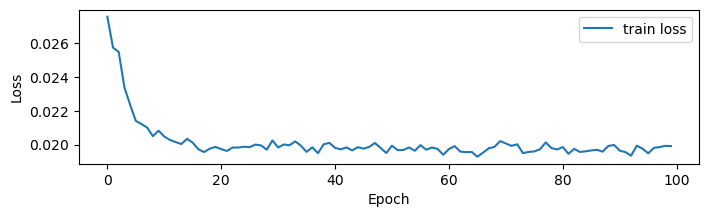

In [421]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), loss_per_epoch, label = "train loss")
#plt.plot(range(epochs), validation_loss, label = 'validation_loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Evaluate model

In [422]:
model.eval()

Model(
  (Encoder): Encoder(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (mu): Linear(in_features=32, out_features=1, bias=True)
    (var): Linear(in_features=32, out_features=1, bias=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=128, bias=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
)

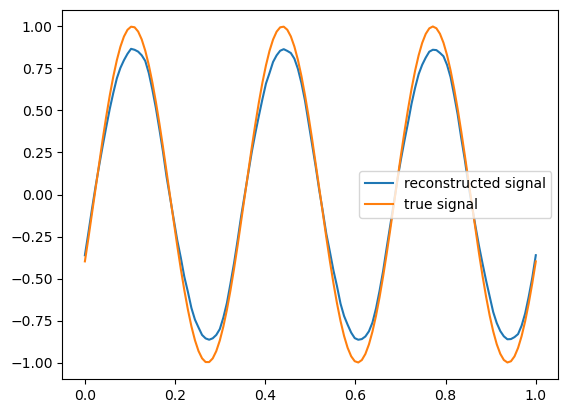

In [423]:
x = train_data[0]
x_hat, _, _ = model(x)
plt.plot(t, x_hat.detach().numpy(), label = 'reconstructed signal')
plt.plot(t, x, label = 'true signal')
plt.legend()
plt.show()

## Using new test data

In [424]:
vae_testdata, test_mean, test_logvar = model(test_data)
avg_reconstruction_loss = nn.functional.mse_loss(test_data, vae_testdata)
print(avg_reconstruction_loss)
avg_reconstruction_loss = np.mean((test_data.detach().numpy() - vae_testdata.detach().numpy())**2)
print(avg_reconstruction_loss)

tensor(0.1105, grad_fn=<MseLossBackward0>)
0.11047908


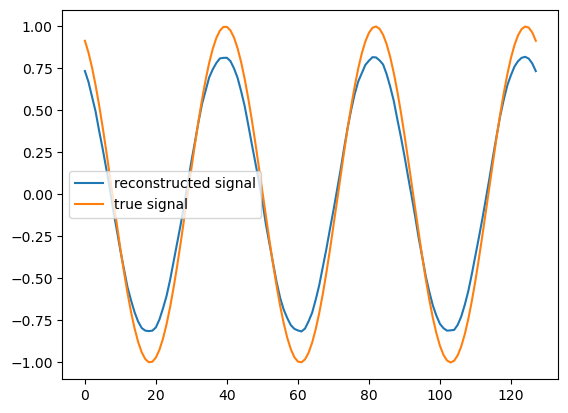

In [425]:
plt.plot(vae_testdata[0].detach().numpy(), label = 'reconstructed signal')
plt.plot(test_data[0], label = 'true signal')
plt.legend()
plt.show()

torch.Size([400, 1])


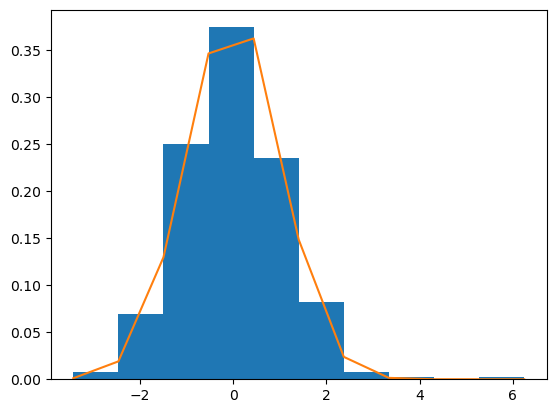

In [426]:
# Distribution of samples in the latent space
import scipy
mean, logvar = model.Encoder(test_data)
std = torch.exp(0.5 * logvar)
latents_test = model.reparametrization(mean, std)
print(latents_test.shape)
n, bins, patches = plt.hist(latents_test.detach().numpy(), bins=10, density=True)
plt.plot(bins, scipy.stats.norm.pdf(bins,0,1))
plt.show()

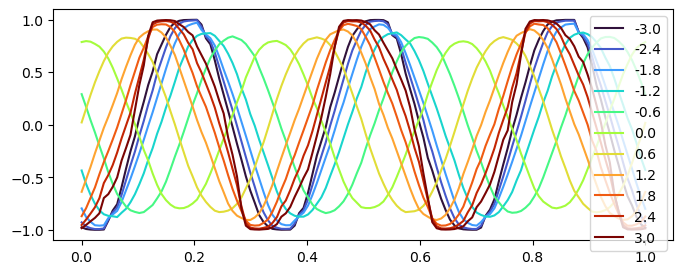

In [427]:
# How do the reconstructed signals depend on the latents?
from tkinter.ttk import LabeledScale
from matplotlib.pylab import cm
plt.figure(figsize=(8,3))
generated_latents = np.repeat(np.linspace(-3, 3, 11)[:,np.newaxis], 1, axis=1)
generated_latents = torch.from_numpy(generated_latents.astype(np.float32))
decoded_x = model.Decoder(generated_latents)

colors = cm.turbo(np.linspace(0,1,len(decoded_x)))
for i, x_hat in enumerate(decoded_x.detach().numpy()):
    plt.plot(t, x_hat, color = colors[i])
labels = [f"{z[0]:.1f}" for z in generated_latents.detach().numpy()]
plt.legend(labels)
plt.show()